# Abstract

The aim of this analysis is to explore and analyze the Palmer Penguins dataset and construct a classifier that can predict the species of penguin (Adelie, Gentoo, Chinstrap) based on the other factors in the data. The findings revealed that a logistic regression model performed the best in predicting the penguin species based on selected features. The model achieved a high accuracy score of 99.6% on the training data and 100% on the test data. We also found the determining features are culmen length, culmen depth, and island location that allow us to classify the penguin species.

First, we'll load the palmer penguins dataset:

In [348]:
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(url)

We'll take a quick peek at how the data looks:

In [349]:
train.head(5)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


# Data Preparation

To format the data into what we want, we'll have to do a few things. First, we'll get rid of the columns that won't help us predict the species of the penguin, in this case: "studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", and "Region". 



In [350]:
train = train.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)

The "Sex" column includes a third sex titled "." in the data that we will remove. We'll also remove any rows with missing data.

In [351]:
train = train[train["Sex"] != "."]
train = train.dropna()

Lastly, we'll convert all our categorical data into numerical data. For our target variable, "Species", we'll use a label encoder. This will assign each label a whole number. For the other columns, we will use one-hot encoding using `pandas.get_dummies` on our dataframe. This will create a new column for each unique value in the column. Our function `prepare_data` will return X_train, the training data without the target variable, and y_train, the training target variable.

In [352]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = 1*pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

Now our data looks like this:

In [353]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,0,1,0,1,0,1,1,0
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,0,1,0,1,0,1,0,1
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,1,0,0,1,0,1,0,1
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,1,0,0,1,0,1,1,0
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,0,1,0,1,0,1,0,1


We can see it's all numerical data now, with many categories containing binary data. Time to explore!

## Explore

#### Creating visualizations to learn about our dataset.

The following table shows the means, minimums, and maximums of each column in the dataset, grouped by island. One thing to point out is that the mean for "Stage_Adult, 1 Egg Stage" is 1.0, therefore it won't help us predict the species. No need to include it in future code! 

Also, the means for the Delta values are very similar across the islands, so we can guess that if we include island in our model, the delta values won't be very helpful in predicting the species.

In [372]:
pd.set_option('display.max_columns', None)
X_train.groupby(["Island_Biscoe", "Island_Dream", "Island_Torgersen"]).agg(["mean", "min", "max"])

Culmen Length (mm)              \
                                                          mean   min   max   
Island_Biscoe Island_Dream Island_Torgersen                                  
0             0            1                         39.350000  34.4  46.0   
              1            0                         44.527835  34.0  58.0   
1             0            0                         44.945600  34.5  55.9   

                                            Culmen Depth (mm)              \
                                                         mean   min   max   
Island_Biscoe Island_Dream Island_Torgersen                                 
0             0            1                        18.441176  15.9  21.5   
              1            0                        18.307216  16.4  21.2   
1             0            0                        15.863200  13.1  21.1   

                                            Flipper Length (mm)                \
                                                           mean    min    max   
Island_Biscoe Island_Dream Island_Torgersen                                     
0             0            1                         192.235294  176.0  210.0   
              1            0                         193.628866  178.0  212.0   
1             0            0                         209.320000  172.0  230.0   

                                            Body Mass (g)                  \
                                                     mean     min     max   
Island_Biscoe Island_Dream Island_Torgersen                                 
0             0            1                  3727.941176  2900.0  4700.0   
              1            0                  3734.793814  2700.0  4800.0   
1             0            0                  4702.000000  2850.0  6300.0   

                                            Delta 15 N (o/oo)           \
                                                         mean      min   
Island_Biscoe Island_Dream Island_Torgersen                              
0             0            1                         8.844635  7.69778   
              1            0                         9.163175  8.01485   
1             0            0                         8.394096  7.63220   

                                                      Delta 13 C (o/oo)  \
                                                  max              mean   
Island_Biscoe Island_Dream Island_Torgersen                               
0             0            1                  9.59462        -25.748135   
              1            0                 10.02544        -25.075329   
1             0            0                  9.79532        -26.086192   

                                                                 \
                                                  min       max   
Island_Biscoe Island_Dream Island_Torgersen                       
0             0            1                -26.53870 -23.90309   
              1            0                -26.69543 -23.89017   
1             0            0                -27.01854 -24.36130   

                                            Stage_Adult, 1 Egg Stage          \
                                                                mean min max   
Island_Biscoe Island_Dream Island_Torgersen                                    
0             0            1                                     1.0   1   1   
              1            0                                     1.0   1   1   
1             0            0                                     1.0   1   1   

                                            Clutch Completion_No          \
                                                            mean min max   
Island_Biscoe Island_Dream Island_Torgersen                                
0             0            1                            0.205882   0   1   
              1            0                            0.123711   0   1   
1 

#### Heatmap

The following visualization shows the correlation between different pairs of variables. Values close to 1 or -1 indicate more linear relationships. 
Given that there are three penguin species, the most helpful visual is one that shows three distinct clumps. This would then likely not be a linear correlation, and so values that are closer to zero may show clumped data. We can see some of the lowest correlations are Culmen Depth vs Culmen Length, Body Mass vs Culmen Depth, and Body Mass vs Culmen Length.

<Axes: >

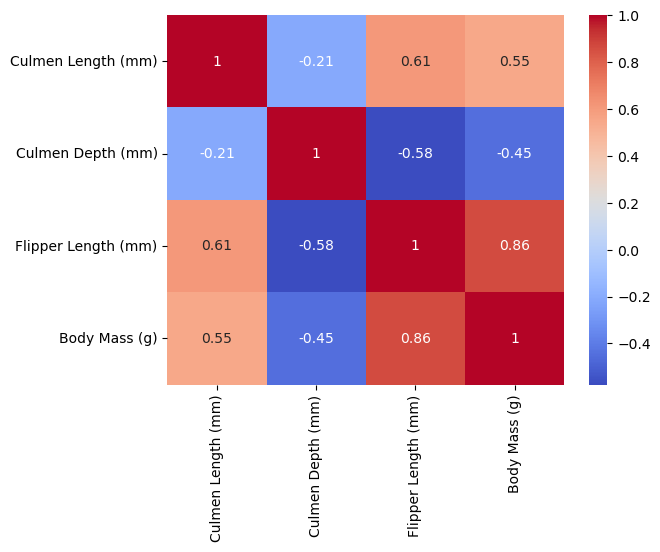

In [356]:
corr = X_train[["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')


#### Scatterplot

The following scatterplot shows the relationship between **Culmen Depth (mm)** on the X-axis and **Body Mass (g)** on the Y-axis. The scatterplot is colored by the sex of the penguin, with purple representing female and orange representing male. This scatterplot shows two distinct clusters of penguins, one in the upper left and the other bottom right. Since we have color-coded by gender, we can see that the clusters are not separated by gender! Perhaps the are separated by Species, in which case this relationship will be very important when creating a classification model. It's likely that one of the penguin species is represented by the cluster in the upper left, and the other two are represented by the cluster in the bottom right. I make this assumption given that the lower right cluster is roughly twice the size of the other.

<Axes: xlabel='Culmen Depth (mm)', ylabel='Body Mass (g)'>

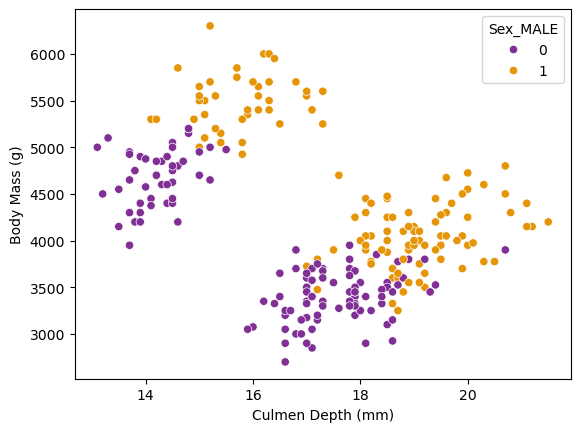

In [357]:
sns.scatterplot(X_train, x="Culmen Depth (mm)", y="Body Mass (g)", hue="Sex_MALE", palette="CMRmap")

# Choosing Features

How will we narrow down the features that will be most helpful in constructing the most accurate model possible?


First, we'll make our modeling functions. One will be for logistic regressions. This will take in ``cols``: the columns we want to use to predict the target variable, ``X``: the training predictor data and ``y``: the training target data. It will create a logistic regression, fit it with the requested columns, and score it.

In [359]:
from sklearn.linear_model import LogisticRegression

def fit_logistic(cols, X, y):
    LR = LogisticRegression(max_iter=99999999)
    LR.fit(X[cols], y)
    return LR.score(X[cols], y)

...and the other will be for decision tree classifiers, also returning the score.

In [360]:
from sklearn.tree import DecisionTreeClassifier

def fit_decision_tree(cols, X, y):
    DTC = DecisionTreeClassifier(max_depth=3, random_state=777)
    DTC.fit(X[cols], y)
    return DTC.score(X[cols], y)


We will use the ``combinations`` function from the ``itertools`` package. This will list all the combinations of one discreet variable and two continuous variables. Iterating through all the possible combinations, it will A) score the models, B) compare the score of the two models (logistic regression vs decision tree), and C) return the best combination of columns and the model that performed the best.

In [361]:
from itertools import combinations

all_qual_cols = ["Island", "Sex"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)", "Flipper Length (mm)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

score = 0
cols_best = []
best_model = None

for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)

        #fit the models
        log_score = fit_logistic(cols, X_train, y_train)
        tree_score = fit_decision_tree(cols, X_train, y_train)

        #compare the scores
        if log_score > tree_score and log_score > score:
            score = log_score
            cols_best = cols
            best_model = "logistic regression"
        elif tree_score > score:
            score = tree_score
            cols_best = cols
            best_model = "decision tree"
        

#output the best score, along with the corresponding columns and model

print(score)
print(cols_best)
print("best model: ", best_model)

0.99609375
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']
best model:  logistic regression


Here we can see that the best model score was for a logistic regression. Using the same columns, we'll use cross-validation to confirm that the logistic regression model is the best model for our data by fitting a decision tree classifier using cross-validation as well and comparing the scores.

In [362]:
from sklearn.model_selection import cross_val_score

log_cross_score = cross_val_score(LogisticRegression(max_iter=99999999), X_train[cols_best], y_train, cv = 5).mean()
tree_cross_score = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=777), X_train[cols_best], y_train, cv = 5).mean()

print(log_cross_score)
print(tree_cross_score)

0.9883107088989442
0.9687028657616894


We can see that the logistic regression model is indeed the most accurate, so we'll use this model for the classifier!

# Testing

Using an untouched test dataset, we will fit our best model found above (logistic regression), using the columns "Culmen Length (mm)", "Culmen Depth (mm)", and the 3 islands, and score it:

In [363]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

LR = LogisticRegression(max_iter=99999999)
LR.fit(X_test[cols_best], y_test)
LR.score(X_test[cols_best], y_test)

1.0

:D

# Plotting Decision Regions

We are going to visualize the decision regions for our logistic regression classifier using the columns that we found to be the most helpful in predicting the species of penguin.

In [364]:
from matplotlib import pyplot as plt
import numpy as np


In [365]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Here is the visualization for the training data using the plot_regions function above:

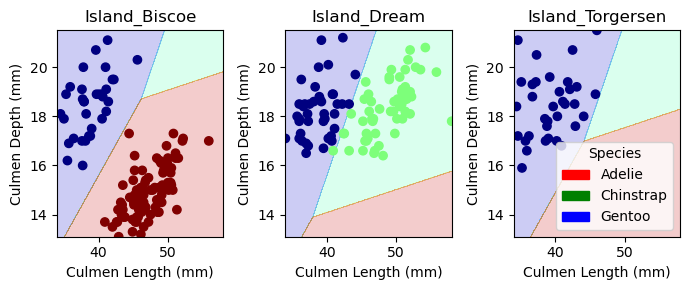

In [366]:
cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]

LR = LogisticRegression(max_iter=99999999)
LR.fit(X_train[cols], y_train)

plot_regions(LR, X_train[cols], y_train)

And here is the visualization for the test data:

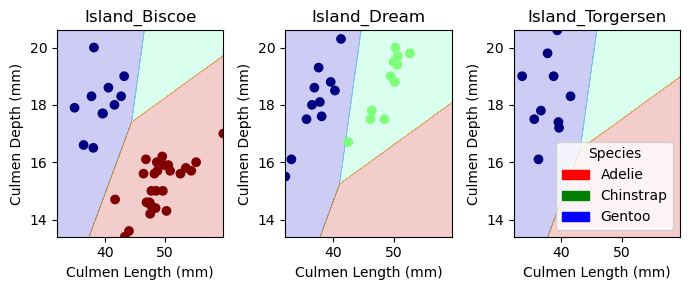

In [367]:
cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]

LR = LogisticRegression(max_iter=99999999)
LR.fit(X_test[cols], y_test)

plot_regions(LR, X_test[cols], y_test)

# Confusion Matrix
Here is a confusion matrix for the model, evaluated on the test set. This shows that the classifier had perfect accuracy. 

In [368]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[32,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

# Discussion

Through this analysis, we have found that the most helpful features in predicting the species of penguin are Culmen Length, Culmen Depth, and the island location. We have also found that a logistic regression model is the most accurate model for predicting the species of penguin based on these features. The model achieved a high accuracy score of 
99.6% on the training data and 100% on the test data. This was a fun process through which I learned how to fit different classification models and compare their accuracy. I also learned how to visualize the decision regions for a classifier and how to create a confusion matrix to evaluate the model. Overall, I'm happy with this analysis and am looking forward to expanding my skills on future projects!